In [144]:
import pandas as pd

data = pd.read_csv('london_weather.csv')
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
data = data.drop(columns=['sunshine']).drop(columns=['cloud_cover']).drop(columns=['global_radiation']).drop(columns=['max_temp'])
data = data.drop(columns=['min_temp']).drop(columns=['precipitation']).drop(columns=['pressure']).drop(columns=['snow_depth'])
data.set_index('date', inplace=True)

In [145]:
data.head()
missing_p = data.isnull().mean()*100
missing_p = missing_p[missing_p > 0]
print (missing_p)
data = data.dropna()

mean_temp    0.234665
dtype: float64


In [146]:
data['mean_temp'] = data['mean_temp'] +10 

<Axes: xlabel='date'>

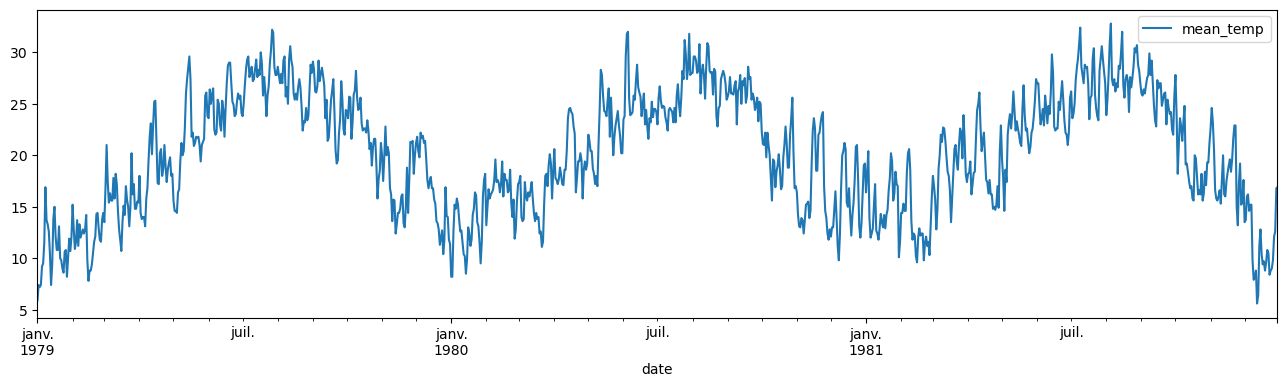

In [147]:
train = data[0:1095]
train.plot(y="mean_temp", figsize= (16,4))

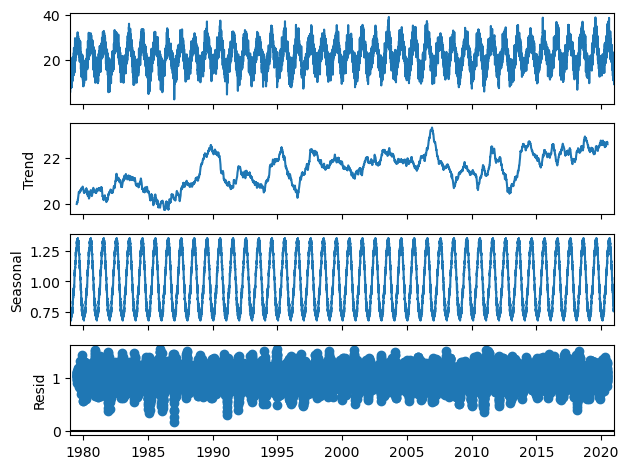

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decompositionM = seasonal_decompose(data, model='multiplicative',period=365)
decompositionM.plot()
plt.show()

In [149]:
from statsmodels.tsa.stattools import adfuller
adfuller(data.mean_temp)[1]

8.265991903892235e-14

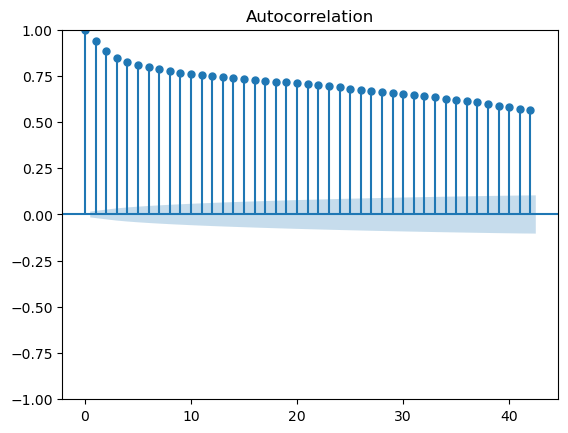

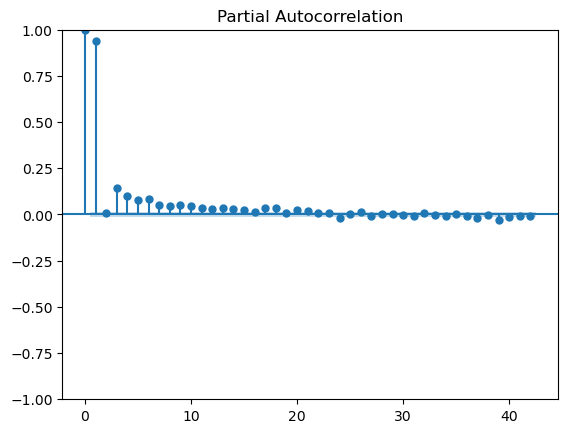

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plot_pacf(data)
plt.show()

In [151]:
from pmdarima import auto_arima

model_auto = auto_arima(data['mean_temp'], seasonal=True, trend='t', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=63005.109, Time=6.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64246.513, Time=2.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64228.024, Time=3.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64217.693, Time=3.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64246.513, Time=2.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=62959.245, Time=5.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=63591.821, Time=4.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63654.972, Time=4.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=63028.229, Time=7.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=63210.477, Time=5.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=63168.486, Time=5.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=62983.581, Time=8.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=62959.245, Time=5.20 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 64.336 seconds


In [152]:
from statsmodels.tsa.arima.model import ARIMA

train = data[0:12000]
test = data[12000:]

model = ARIMA(train, order=(1,1,2))
model_fit = model.fit()

c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


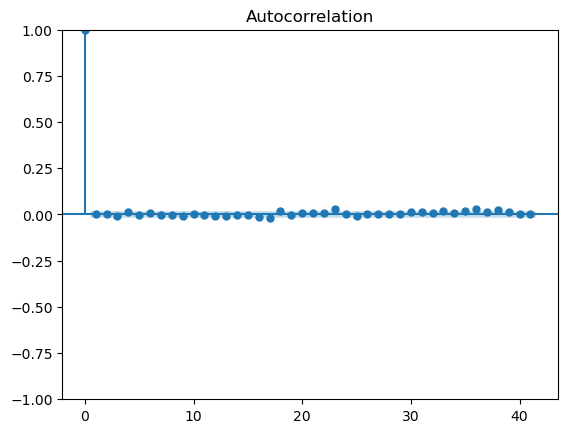

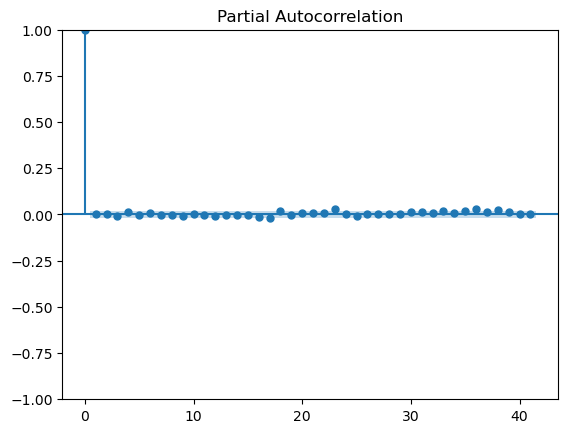

In [153]:
residuals = model_fit.resid
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

In [154]:
import numpy as np
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='b')
    plt.plot(test, label='actual', color='b', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)

c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


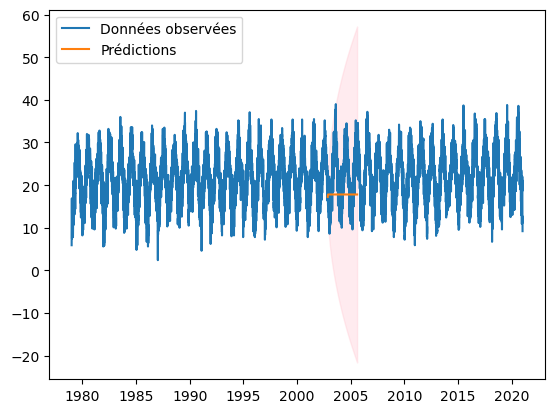

In [156]:
forecast = model_fit.get_forecast(steps = 1000)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Affichage des prévisions avec intervalle de confiance
plt.plot(data, label="Données observées")
plt.plot(forecast_mean, label="Prédictions")
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()